# Lab 4: Recurrent models

This lab gives you practice with embeddings (word vectors, in this case) and recurrent neural models in NLP. The first part focuses on embeddings as input to a recurrent model, and the second part focuses on embeddings derived from recurrent models, applying them to the task of word sense disambiguation following the approach from the original paper by [Peters et al. (2018)](https://aclanthology.org/N18-1202.pdf)

# Rules
* The assignment should be submitted to **Blackboard** as `.ipynb` (without data files or zipping). Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.

* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header(!).

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells.
* Don't change the names of provided functions and variables or arguments of the functions.
* Leave the output of your code in the output cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>

# <font color="red">Contributions</font>

* Jose Luis Cano-Manuel Claver: 2.1, 2.2, 2.3
* Raquel González López: 1.1-1.4a, 2.2, 2.3
* Ruben Kole: 1.1-1.4

but everyone assisted on each other's sections.

# Part 1 [40pt] POS tagging with LSTM

In the first part of lab 4, we will play with training a recurrent model for part of speech tagging. We start with implementing the evaluation and training procedures for LSTM-based tagger. Initially we will work on the toy data so that you understand the procedures. Later we use the Brown corpus with Universal POS tags. We will train a tagger on the data and analyse the training dynamics. Then we will use pre-trained word embeddings to initialize an LSTM. We will experiment with training taggers with and without pre-trained word vectors.

## Setup

In [ ]:
import random, math
import nltk
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm

In [ ]:
# torch-specific code
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [ ]:
print(f"NLTK version: {nltk.__version__}")
print(f"torch version: {torch.__version__}")

NLTK version: 3.8.1
torch version: 2.0.1+cu118


In [ ]:
# download several data incorporated in NLTK
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('semcor')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Some auxiliary functions that will be reused throughout the notebook

def plot_numbers(num_listm, xlabel="Epochs", ylabel="Loss", label=None):
    """ Visualizes a list of numbers as a line plot
    """
    plt.plot(np.arange(len(num_listm)), num_listm, 'o-', markersize=2, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if label: plt.legend()

# Let's plot the loss values and see how training on more epochs decreases the loss value
def plot_results(res, parts=("train", "valid"), metrics=("loss", "acc"), title=None):
    """ Shorthand for contrasting loss and accuracy numbers obtained on different datasets
    """
    for m in metrics:
        for p in parts:
            plot_numbers(res[p][m], label=f"{p} {m}", ylabel=m)
        if title: plt.title(title)
        plt.show()

def train_validation_split(sequence, train_ratio, valid_ratio, seed=0, seperate_tags=False):
    """ returns two non-overlapping subpart of the input sequence.
        The sizes of the parts satisfies the size ration constraint.
        If seperate_tags is on, this means the input has format of [(w1,pos1), (w2,pos2)]
        and it will be converted to [(w1,w2), (pos1,pos2)]
    """
    assert train_ratio + valid_ratio <= 1
    population = list(sequence)
    n = len(population)
    train_num, valid_num = math.floor(n * train_ratio), math.floor(n * valid_ratio)
    random.seed(seed)
    data = random.sample(population, train_num + valid_num)
    if seperate_tags:
        data = [ list(zip(*sent)) for sent in data ]
    return data[:train_num], data[train_num:]

## LSTM tagger

Read the [pytorch tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) on sequence tagging with LSTM. It is very important that you practice how to read and understand the tutorials on web. Not all tutorials are written in a clear way, and understanding the overlooked parts requires practice and effort.
Fortunately, the aforementioned tutorial is very well written. Though it uses many new operations related to tensors (=a multi-dimensional matrix containing elements of a single data type).

Pytorch is well documented and almost any function, method, or class can be looked up [here](https://pytorch.org/docs/stable/index.html), in the top-left corner. For example, `torch.randn` is defined [here](https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn). Note that keywords in the code of the tutorial are hyperlinks with links to the corresponding documentation.

The code below is copied from the tutorial page as we will reuse certain variables and functions. We only renamed the data variable name to indicate that it is toy data.

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


toy_training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in toy_training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


The code below is also copied from the tutorial but it incorporates two additions:

1.   Fixing the torch's random generator seeds: see `nn_seed` and `em_seed`. These seeds control the initialization of `self.word_embeddings` from [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) and `self.lstm` from [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). In the first case, the `vocab_size` number of `embedding_dim`-dimensional tensors are generated, while in the second case the LSTM network is initialized with random weights (note that `self.hidden2tag` is also randomized weights denoting `V` matrix, from J&M chapter 9, that is used to obtain output from the hidden layer for each time step). We make the LSTM initialization based on the seed to maintain replicability of the same results.

2.   Making the class flexible to allow initialization from pre-trained word embeddings. `embedding` input can be a tuple that specifies the dimensions of the embedding layer or a ready tensor that records pre-trained word embeddings.

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, hidden_dim, tagset_size, nn_seed=0, em_seed=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        if isinstance(embedding, torch.Tensor):
            self.word_embeddings = nn.Embedding.from_pretrained(embedding)
            embedding_dim = self.word_embeddings.weight.size(1)
        else:
            torch.manual_seed(em_seed)
            vocab_size, embedding_dim = embedding
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        torch.manual_seed(nn_seed)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Ex1.1a [7pt] Evaluation

The training (i.e. last) code in the [tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging) contains lines of code that we will reuse several times. That's why we are going to make specific functions out of them. The first function we will make takes a model and data (and other stuff) and returns predictions and metrics wrapped in a dictionary. read the function definition carefully for more details.

In [ ]:
def evaluate_tagger(model, data, w2i=None, t2i=None, get_tags=False, get_scores=False):
    """ model - an NN model, in particular an LSTMTagger object
        data - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices, when w2i is not specified this means that
            tokens are already mapped to indices and no mapping is needed. This option
            will be handy when evaluating a tagger several times on a data during the training.
        t2i - a dict mapping POS tags to indices. When t2i is not specified this means that
            pos tags are already mapped to indices in data and also when returning tags
            as an output, they won't be mapped to human readable tags, but instead returned
            as indices.
        get_tags - whether return predicted tags (i.e., most probable tag per token)
        get_scores - whether to return actual tag scores for each token
    return:
        a dictionary with keys 'loss', 'acc', 'scores', 'tags'.
        The keys are present in the dictionary for certain values according to the input.
        For example, if get_tags=False, there shouldn't be 'tags' key in the dictionary.
        As an example, see the reference output below.
    """
    ### YOUR CODE HERE ###

    # define loss function as the negative log likelihood loss, as the tutorial
    loss_function = nn.NLLLoss()

    # intialize the variables that will be used later in the code
    tags, scores = [], []
    total_loss = 0.0
    total_preds, correct_preds = 0, 0

    # wrapped the code in torch.no_grad()
    with torch.no_grad():
      # iterate over the tokens and tag in the data
      for token, tag in data:
        # use the prepare_sequence funtion to turn the inputs (token and tags) into Tensors of word indices.
        inputs = prepare_sequence(token, w2i)
        # insert inputs into the model, run forward pass
        tag_scores = model(inputs)
        targets = prepare_sequence(tag, t2i)

        # compute the loss
        loss = loss_function(tag_scores, targets)
        total_loss += loss.item()

        # get the position of the maximums in the output from the model
        preds = np.argmax(tag_scores, axis = 1)

        # check if the get_tags option is True, then retrieve the keys from the dictionary and append the desired tags to a list
        if get_tags:
          p = [list(t2i.keys())[i.item()] for i in preds]
          tags.append(p)
        # check if the get_scores option is True, and append the output scores to a list
        if get_scores:
          scores.append(tag_scores)

        # compute the total numer of predictions which corresponds to its length
        total_preds += len(preds)
        # calculate the number of correct predictions by comparing the predictions to the targets
        correct_preds += np.sum(preds.numpy() == targets.numpy())

    # append the loss and accuracy values to the results dictionary
    eval_dict = {
        'loss' : total_loss / len(data),
        'acc' : correct_preds / total_preds
    }

    # if this options are True, also add its values to th dictionary
    if get_tags:
      eval_dict['tags'] = tags
    if get_scores:
      eval_dict['scores'] = scores

    return eval_dict

In [ ]:
# TEST Ex1.1
# deterministically initialize LSTM tagger and predict the tags for the data
toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# evaluate tagger
pred = evaluate_tagger(toy_tagger, toy_training_data, w2i=word_to_ix, t2i=tag_to_ix, get_tags=True, get_scores=True)
print(pred)

print("Tokens, gold tags, and predicetd most probable tag per token")
for (sent, tags1), tags2 in zip(toy_training_data, pred['tags']):
    for seq in (sent, tags1, tags2):
        print(''.join([ f"{el:^8}" for el in seq ]))

{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple  
  DET      NN      V      DET      NN   
   NN      NN     DET      NN      NN   
Everybody  read    that    book  
   NN      V      DET      NN   
   NN     DET     DET      NN   


Reference output:

```
{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple
  DET      NN      V      DET      NN
   NN      NN     DET      NN      NN
Everybody  read    that    book
   NN      V      DET      NN
   NN     DET     DET      NN
```

## Q1.1b [4pt] Explain predictions



1.   *Given the above predictions from the tagger, is there any rationale for why the tagger predicts NN often?*
2.   *What is the predicted probability distribution over the tags for "that" in the data*? In case your tagger's output is different from the reference output, make clear which output your answer is based on.



<font color="red">█████ YOUR ANSWER HERE █████</font>

1. First of all, most tags in the training data are nouns. They are overrepresented and therefore the chance that a word gets assigned this tag is increased.
2. It is the tensor in position 2 of the second "scores": [-0.9478, -1.0155, -1.3856]

## Ex1.2: [10pt] Training

We need to write a function that trains a model on the data. This function later will be reused for training the tagger on different training sets. Again, reuse the code from the tutorial page to complete the body of the function. Keep the learning rate the same. During training often the training data is shuffled, but here, for simplicity, don't shuffle the data, keep it as it is.
Note that the function has to return the list of loss and accuracy values that is one item longer than the number of epochs.
Don't forget to **reuse** `evaluate_tagger` function.
Read the function definition for more details.

**Hints**: the function presupposes training/evaluating a model on the same data several times. Make sure that you convert the data into tensors once and not for every epoch.
Feel free to define sub-functions that will be reused for train and valid parts. This will make the code less redundant.
The tqdm module gives a nice way to report the progress of training.

In [ ]:
def train_tagger(model, train, w2i, t2i,
                 valid=None, epoch_num=10, verbose=False):
    """ model - an NN model, in particular an LSTMTagger object
        train - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices
        t2i - a dict mapping POS tags to indices
        valid - optional validation data structurally identical to train.
            When the validation data is provided, the output also records results about it.
        epoch_num - the number of times to train the model on the train data
        verbose - a flag that makes the function print various useful info. For example,
            it can be used to turn on/off the tqdm progress bar during the training.

        return:
            a dictionary with keys 'train' and 'valid', the existence of the latter depends
            on whether the valid arg is provided. The values of the keys are dictionaries
            with keys 'loss', 'acc', 'best_acc'. The first two have a list value of length epoch_num + 1.
            This is because it includes the loss & acc of the initial model and the final too.
            Note that the loss value is averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
            'best_acc' keeps the max values from the 'acc' list.
            See the reference output below as an example.
    """
    ### YOUR CODE HERE ###

    # define the negative log likelihood as the loss function
    loss_function = nn.NLLLoss()
    # define the stochastic gradient descent as the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # intialize the results dictionary with the train and valid keys and inside of each, its own keys
    results = {
        "train" : {"loss" : [], "acc" : [], "best_acc" : 0.0},
        "valid" : {"loss" : [], "acc" : [], "best_acc" : 0.0}
    }

    # call the previously defined function evaluate_tagger  with the training data to obtain the necessary initial values
    preds_train = evaluate_tagger(model, train, w2i, t2i, get_tags=True, get_scores=True)
    results["train"]["loss"].append(preds_train["loss"])
    results["train"]["acc"].append(preds_train["acc"])

    # if this option is valid, do the same for the validation data
    if valid:
      preds_valid = evaluate_tagger(model, valid, w2i, t2i, get_tags=True, get_scores=True)
      results["valid"]["loss"].append(preds_valid["loss"])
      results["valid"]["acc"].append(preds_valid["acc"])

    # loop over the number of epochs
    for epoch in range(epoch_num):
      # initialize some variables that are needed to compute the loss and preditions values
      total_loss = 0
      correct_preds = 0
      total_preds = 0
      # loop over the sentences and tags in the data
      for sentence, tags in train:
        # clear gradients before each instance to avoid accumulating gradients
        model.zero_grad()

        # convert data to tensors to input the network
        sentence_in = prepare_sequence(sentence, w2i)
        targets = prepare_sequence(tags, t2i)

        tag_scores = model(sentence_in)

        # compute the loss function, gradients, and update paramenters by calling the optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

      # again, call the evaluate_tagger function to extract the desired values given the new inputs
      preds_train = evaluate_tagger(model, train, w2i, t2i, get_tags=True, get_scores=True)

      # add those values to the results dictionary
      results["train"]["loss"].append(preds_train["loss"])
      results["train"]["acc"].append(preds_train["acc"])
      results["train"]["best_acc"] = max(results["train"]["acc"])

      if valid:
        preds_valid = evaluate_tagger(model, valid, w2i, t2i, get_tags=True, get_scores=True)
        results["valid"]["loss"].append(preds_valid["loss"])
        results["valid"]["acc"].append(preds_valid["acc"])
        results["valid"]["best_acc"] = max(results["valid"]["acc"])

    return results

In [ ]:
# TEST Ex1.2-1
# defining a toy validation set
toy_validation_data = [
    ("The dog read that book".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody ate the apple".split(), ["NN", "V", "DET", "NN"])
]
# initialize the model
trained_toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# train and retrieve the loss values per epoch
res = train_tagger(trained_toy_tagger, toy_training_data, word_to_ix, tag_to_ix, valid=toy_validation_data, epoch_num=200)
print(f"results: {res}")

results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.0281798839569092, 1.0263945162296295, 1.0245959758758545, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821900725364685, 0.9795820713043213, 0.9769113957881927, 0.97417587041854

Reference output
```
results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.0281798839569092, 1.0263945162296295, 1.0245959758758545, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821900725364685, 0.9795820713043213, 0.9769113957881927, 0.9741758704185486, 0.971373051404953, 0.968500405550003, 0.9655555188655853, 0.9625357389450073, 0.9594384133815765, 0.9562608897686005, 0.9530004262924194, 0.9496542811393738, 0.9462195336818695, 0.9426933825016022, 0.9390727579593658, 0.9353549182415009, 0.9315365552902222, 0.9276146292686462, 0.9235861897468567, 0.9194479286670685, 0.9151966571807861, 0.9108293950557709, 0.9063427448272705, 0.9017335474491119, 0.8969985246658325, 0.8921345770359039, 0.8871385455131531, 0.8820073008537292, 0.8767377138137817, 0.8713269233703613, 0.8657719492912292, 0.8600700199604034, 0.8542185723781586, 0.8482151329517365, 0.8420574069023132, 0.8357434272766113, 0.8292712569236755, 0.8226395547389984, 0.8158469200134277, 0.8088927268981934, 0.8017762303352356, 0.7944974899291992, 0.7870568335056305, 0.779455155134201, 0.7716937363147736, 0.7637743949890137, 0.7556994557380676, 0.747471958398819, 0.7390953898429871, 0.7305739521980286, 0.7219121754169464, 0.7131155133247375, 0.7041897773742676, 0.6951413750648499, 0.685977429151535, 0.6767054200172424, 0.6673334836959839, 0.657869964838028, 0.64832404255867, 0.6387049555778503, 0.6290224492549896, 0.6192863881587982, 0.6095071136951447, 0.5996948778629303, 0.5898602306842804, 0.5800137519836426, 0.5701659321784973, 0.5603272318840027, 0.5505081117153168, 0.5407186597585678, 0.5309689044952393, 0.5212685018777847, 0.5116268247365952, 0.5020530223846436, 0.49255549907684326, 0.4831426292657852, 0.47382208704948425, 0.4646011292934418, 0.455486536026001, 0.44648461043834686, 0.43760116398334503, 0.42884135246276855, 0.420210063457489, 0.4117113947868347, 0.4033491313457489, 0.3951266258955002, 0.38704653084278107, 0.379111185669899, 0.37132251262664795, 0.36368197202682495, 0.35619062185287476, 0.34884922206401825, 0.3416580855846405, 0.3346172273159027, 0.32772640883922577, 0.3209850490093231, 0.3143923729658127, 0.30794721841812134, 0.3016485273838043, 0.2954946607351303, 0.2894841134548187, 0.28361500799655914, 0.27788545936346054, 0.27229342609643936, 0.2668367102742195, 0.26151304692029953, 0.25632014125585556, 0.2512555569410324, 0.24631685763597488, 0.24150147289037704, 0.23680689930915833, 0.23223048448562622, 0.22776974737644196, 0.22342193126678467, 0.2191845253109932, 0.21505482494831085, 0.21103034913539886, 0.20710836350917816, 0.20328643918037415, 0.19956187903881073, 0.1959322690963745, 0.19239506870508194, 0.18894780427217484, 0.18558815866708755, 0.1823136806488037, 0.17912207543849945, 0.17601102590560913, 0.17297829687595367, 0.17002175748348236, 0.1671391949057579, 0.16432850062847137, 0.16158772259950638, 0.15891478210687637, 0.15630778670310974, 0.15376483649015427, 0.1512840986251831, 0.1488637775182724, 0.14650212973356247, 0.14419741183519363, 0.14194803684949875, 0.13975241407752037, 0.13760895282030106, 0.13551612943410873, 0.13347259163856506, 0.13147679716348648, 0.12952743843197823, 0.12762318551540375, 0.1257627233862877, 0.12394478917121887, 0.12216819450259209, 0.12043173983693123, 0.11873431876301765, 0.11707473546266556, 0.11545206606388092, 0.11386516317725182, 0.11231311783194542], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}, 'valid': {'loss': [1.0846959352493286, 1.0808380246162415, 1.0773123502731323, 1.074073314666748, 1.0710812211036682, 1.0683015584945679, 1.0657045245170593, 1.0632638335227966, 1.0609570741653442, 1.0587645769119263, 1.0566694736480713, 1.0546568036079407, 1.0527135729789734, 1.050828456878662, 1.048991858959198, 1.0471948385238647, 1.0454300045967102, 1.0436905026435852, 1.0419704914093018, 1.04026460647583, 1.0385679006576538, 1.0368764400482178, 1.0351861119270325, 1.0334933400154114, 1.031795084476471, 1.0300881266593933, 1.0283698439598083, 1.0266374945640564, 1.0248886346817017, 1.0231209993362427, 1.0213320851325989, 1.0195199251174927, 1.0176822543144226, 1.015817105770111, 1.0139222741127014, 1.0119959115982056, 1.010036051273346, 1.008040428161621, 1.0060072541236877, 1.0039344429969788, 1.0018200278282166, 0.9996618628501892, 0.9974577724933624, 0.9952059388160706, 0.992904007434845, 0.9905498921871185, 0.9881412386894226, 0.9856758415699005, 0.9831514060497284, 0.9805654585361481, 0.9779156148433685, 0.975199431180954, 0.9724143147468567, 0.9695577323436737, 0.9666268825531006, 0.9636191427707672, 0.9605317711830139, 0.9573618173599243, 0.9541065096855164, 0.950762927532196, 0.9473278522491455, 0.9437984228134155, 0.940171480178833, 0.936443954706192, 0.9326125979423523, 0.9286741614341736, 0.9246255159378052, 0.9204634130001068, 0.9161844551563263, 0.9117855131626129, 0.9072633981704712, 0.9026147425174713, 0.8978364765644073, 0.8929254114627838, 0.8878785669803619, 0.8826929926872253, 0.8773658275604248, 0.8718942999839783, 0.8662759959697723, 0.8605084121227264, 0.854589432477951, 0.8485172688961029, 0.8422901332378387, 0.8359066545963287, 0.8293657600879669, 0.8226668834686279, 0.8158095479011536, 0.8087940514087677, 0.8016207814216614, 0.7942907512187958, 0.7868053317070007, 0.7791665494441986, 0.7713768780231476, 0.7634392380714417, 0.755357176065445, 0.7471347451210022, 0.7387764751911163, 0.7302875816822052, 0.7216735482215881, 0.7129406034946442, 0.7040953636169434, 0.6951448917388916, 0.6860966384410858, 0.6769585013389587, 0.667738676071167, 0.658445805311203, 0.6490887403488159, 0.6396763920783997, 0.6302180886268616, 0.6207231283187866, 0.6112009882926941, 0.6016610860824585, 0.5921128392219543, 0.5825656354427338, 0.5730288028717041, 0.5635112524032593, 0.5540220439434052, 0.5445697605609894, 0.5351628661155701, 0.5258093178272247, 0.5165170133113861, 0.5072932541370392, 0.49814508855342865, 0.4890791177749634, 0.48010173439979553, 0.4712185859680176, 0.46243521571159363, 0.45375658571720123, 0.44518721103668213, 0.43673138320446014, 0.42839284241199493, 0.4201749265193939, 0.41208066046237946, 0.4041126221418381, 0.3962731957435608, 0.38856421411037445, 0.38098737597465515, 0.3735438734292984, 0.3662347346544266, 0.35906076431274414, 0.3520224094390869, 0.3451198488473892, 0.3383530527353287, 0.3317219018936157, 0.3252258598804474, 0.3188643902540207, 0.3126366436481476, 0.30654168128967285, 0.30057843029499054, 0.2947455793619156, 0.28904177248477936, 0.28346555680036545, 0.27801529318094254, 0.27268923819065094, 0.26748569309711456, 0.26240262389183044, 0.2574382796883583, 0.25259044021368027, 0.24785716831684113, 0.24323634058237076, 0.23872575163841248, 0.23432327806949615, 0.23002667725086212, 0.2258337214589119, 0.2217421904206276, 0.21774984151124954, 0.21385441720485687, 0.21005363762378693, 0.20634539425373077, 0.20272734761238098, 0.1991974264383316, 0.1957533359527588, 0.1923929899930954, 0.1891142502427101, 0.18591507524251938, 0.18279334902763367, 0.17974704504013062, 0.1767742782831192, 0.17387297004461288, 0.17104127258062363, 0.16827736794948578, 0.16557937115430832, 0.16294549405574799, 0.1603739634156227, 0.157863087952137, 0.15541130304336548, 0.1530168540775776, 0.15067820623517036, 0.1483938843011856, 0.14616229385137558, 0.14398206025362015, 0.1418517380952835, 0.13976992666721344, 0.1377352774143219, 0.1357465460896492, 0.1338024064898491, 0.13190167769789696, 0.13004306703805923, 0.12822554260492325, 0.1264479085803032, 0.12470909580588341], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}}

```

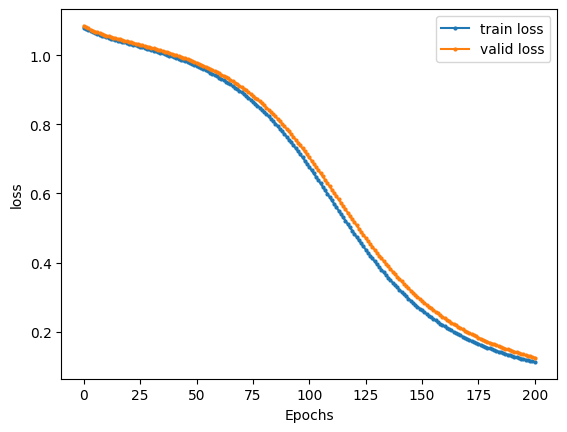

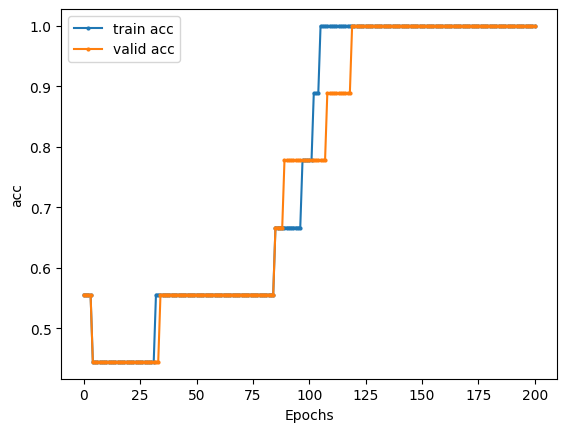

In [ ]:
# TEST Ex1.2-2
# DON'T DELETE THE OUTPUT
plot_results(res)

## Brown corpus

In this exercise we use the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) for English annotated with the [Universal POS (UPOS) tags](https://universaldependencies.org/u/pos/). We can access the data from an NLTK's corpus list. Note that the UPOS tagset contains much fewer tags than the PennTreebank POS tags. This makes UPOS tagging relatively easy.

You are provided with a function `train_validation_split` which extracts two subsets from the given corpus. The size of the subsets can be specified in terms of the ratio to the entire corpus size.

In [ ]:
# defining the corpus view (of type ConcatenatedCorpusView), which can be iterated
BROWN_UPOS = nltk.corpus.brown.tagged_sents(tagset='universal')
# Peeking inside the data
print(BROWN_UPOS[:2])

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
# This is how to get training and validation parts of different sizes from the data
# we use seperate_tags=True to format the extracted parts according to the format of the toy datasets,
# i.e., putting tokens and their POS tags in separate lists
sample_train_data, sample_valid_data = train_validation_split(BROWN_UPOS, 0.1, 0.1, seperate_tags=True)
print(f"Training data ({len(sample_train_data)}) and validation data ({len(sample_valid_data)})")

Training data (5734) and validation data (5734)


## Ex1.3a [5pt] Train UPOS tagger

Write a code that initializes a new LSTM tagger with the **embedding dimensionality 32** and **hidden layer dimensionality 16**.
We are opting for the low-dimensional representations to keep the training time reasonable on CPUs.
Note that you will also need to create the mappings of words and tags to indices based on the data.

Train the tagger on `sample_train_data` with **100 epochs** and evaluate on `sample_valid_data` using your `train_tagger` function. Save the training results in `upos_res` which will be plotted by the test cell.

In [ ]:
### YOUR CODE HERE ###
# save results in upos_res
# should take 30-45min on colab's cpu

# create words/tags mapping to indices based on the current data
word_to_ix_upos = {}
tag_to_ix_upos = {}

for sentence in BROWN_UPOS:
  for word, tag in sentence:
    if word not in word_to_ix_upos:
        word_to_ix_upos[word] = len(word_to_ix_upos)
    if tag not in tag_to_ix_upos:
        tag_to_ix_upos[tag] = len(tag_to_ix_upos)

# initialize the model
trained_upos_tagger = LSTMTagger((len(word_to_ix_upos), 32), 16, len(tag_to_ix_upos))
# train and retrieve the loss values per epoch
upos_res = train_tagger(trained_upos_tagger, sample_train_data, word_to_ix_upos, tag_to_ix_upos, valid=sample_valid_data, epoch_num=100)

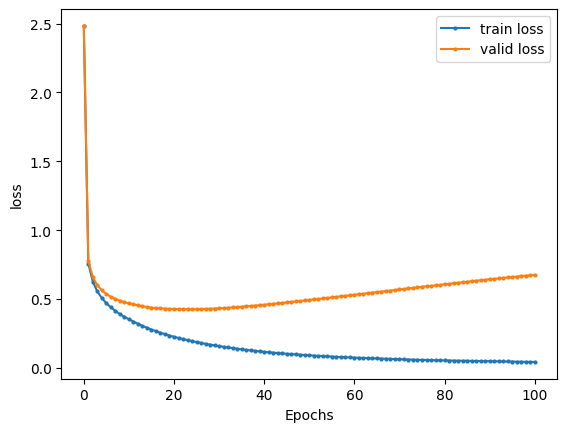

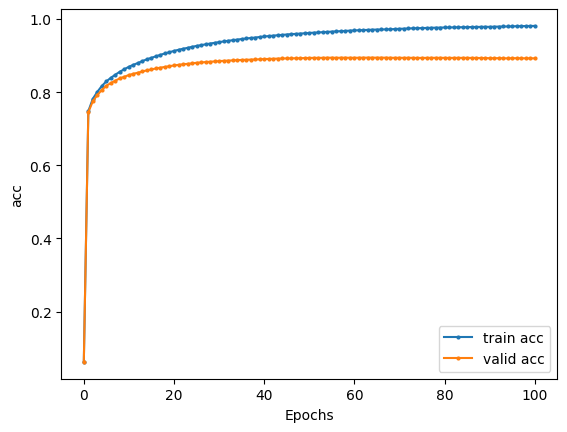

In [ ]:
# TEST Ex1.3
# DON'T DELETE THE OUTPUT
plot_results(upos_res)

## Q1.3b [2pt] Best model

Based on the training dynamics of the accuracy scores on the training and validation parts, after which epoch (if any) is recommended to stop training and why?

<font color="red">█████ YOUR ANSWER HERE █████</font>

After the validation score is at its lowest, the training should stop. In this case it seems like this is around epoch 20. After this, the model starts overfitting. This happens because the model stops being able to generalize and then it becomes impossible for the model to apply what it has learned to data from the test set.

## GloVe embeddings

In this section we are downloading the [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained static word embeddings. We will reuse it to initialize the embedding layer of an LSTM, as opposed to the random initialization we have been using so far.

In [ ]:
# downloading from the Dutch server (should be a bit faster than the original source)
GLOVE_FILE = "glove.6B.100d.txt"
!wget -nv https://naturallogic.pro/_files_/download/mNLP/{GLOVE_FILE}.bz2
!bzip2 -dk glove.6B.100d.txt.bz2

2023-06-26 07:53:34 URL:https://naturallogic.pro/_files_/download/mNLP/glove.6B.100d.txt.bz2 [107798047/107798047] -> "glove.6B.100d.txt.bz2" [1]


In [ ]:
# Loading vectors from the file
glove = torchtext.vocab.Vectors(GLOVE_FILE, cache=".")
print(glove.vectors.shape)

100%|█████████▉| 399999/400000 [00:17<00:00, 22339.51it/s]


torch.Size([400000, 100])


GloVe comes with its own word-to-index mapping: `stoi` (strings to indices).

You can access each word's vector as shown below.

In [ ]:
word1 = "test" #@param {type:"string"}
word2 = "train" #@param {type:"string"}
if word1 and word2:
    tensor1 = glove.vectors[glove.stoi[word1]]
    tensor2 = glove.vectors[glove.stoi[word2]]
    sim = F.cosine_similarity(tensor1, tensor2, dim=0).item()
    print(f"similarity({word1}, {word2}) = {sim}")
elif word1:
    print(f"The index is {glove.stoi[word1]}")
    print(f"The vector is {glove.vectors[glove.stoi[word1]]}")

similarity(test, train) = 0.40102818608283997


## Ex1.4a [10pt] Random vs GloVe

In this exercise we are comparing two LSTM-based UPOS taggers, one with randomly initialized embeddings while another reusing the GloVe embeddings.
To bolster the comparison, we will restrict the data only to those tagged sentences that consist of the words covered by the GloVe vectors (Note that GloVe covers 400K words). This also helps to reduce the data and make the experiments feasible for the colab's CPU.

Complete the designated code cell below so that it runs the following experiment:

1.   For each train & valid data split initialize two LSTM-based taggers, with the random and GloVe embeddings.
2.   Train each tagger with a predefined number of epochs. Obviously, you should reuse `train_tagger` function here.
3.   After the training is done, record the max/best score across the epochs on the validation part (because the validation score better represents the model's capacity than the training data). Use `best_valid_acc` to keep track of the best scores for each type of embedding initialization.

One important detail! This is an example of how to initialize an LSTM tagger with the GloVe word vectors that is expected to predict $N$ number of tags.
Remember, this was the reason why we modified the LSTMTagger class from the PyTorch tutorial.

```
LSTMTagger(glove.vectors, HIDDEN_DIM, N)
```

In [ ]:
EMB_DIM = glove.vectors.size(1)
HID_DIM = 20
valid_ratio = 0.2
train_ratios = [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8]
epoch_num = 50
# keep the best accuracy on the valid part here. Keys
best_valid_acc = {'glove':[], 'random':[]}
# For better contrast, we are keeping only those sentences in the Brown corpus for which we have GloVe vectors
GLOVE_BROWN = [ sent for sent in BROWN_UPOS if all([ w in glove.stoi for w, _ in sent ]) ]
print(f"New data size = {len(GLOVE_BROWN)}")

New data size = 2062


In [ ]:
# It should take under 30mins
### YOUR CODE HERE ###
word_to_ix_glove = {}
tag_to_ix_glove = {}

# create the mapping of words
for sentence in GLOVE_BROWN:
  for word, tag in sentence:
    if word not in word_to_ix_glove:
        word_to_ix_glove[word] = len(word_to_ix_glove)
    if tag not in tag_to_ix_glove:
        tag_to_ix_glove[tag] = len(tag_to_ix_glove)

# loop over the train_ratios lists and compute the best accuracy for each case
for train_ratio in train_ratios:
  sample_train_data_glove, sample_valid_data_glove = train_validation_split(GLOVE_BROWN, train_ratio, valid_ratio, seperate_tags=True)

  random_tagger = LSTMTagger((len(word_to_ix_glove), EMB_DIM), HID_DIM, len(tag_to_ix_glove))
  random_res = train_tagger(random_tagger, sample_train_data_glove, word_to_ix_glove, tag_to_ix_glove, valid = sample_valid_data_glove, epoch_num = epoch_num)

  glove_tagger = LSTMTagger(glove.vectors, HID_DIM, len(tag_to_ix_glove))
  # use GloVe word-to-ix own mapping
  glove_res = train_tagger(glove_tagger, sample_train_data_glove, glove.stoi, tag_to_ix_glove, valid = sample_valid_data_glove, epoch_num = epoch_num)

  best_valid_acc["glove"].append(glove_res["valid"]["best_acc"])
  best_valid_acc["random"].append(random_res["valid"]["best_acc"])

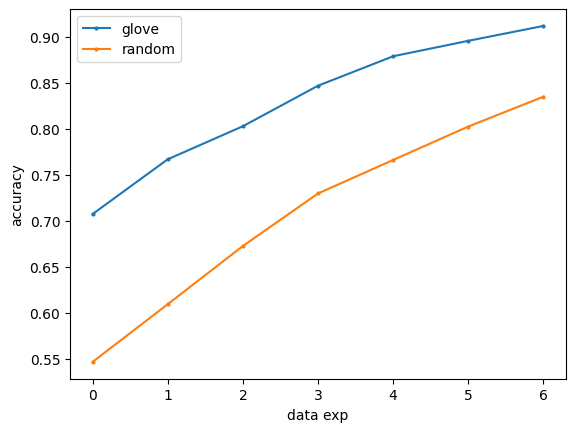

In [ ]:
# TEST 1.4
# DON'T DELETE THE OUTPUT
plot_numbers(best_valid_acc['glove'], label='glove', ylabel='accuracy', xlabel='data exp')
plot_numbers(best_valid_acc['random'], label='random', ylabel='accuracy', xlabel='data exp')

## Q1.4b [2pt] Conclusion

Based on the plots of the best accuracy scores on the validation part, how would you compare the use of randomized embeddings to the use of pre-trained embeddings?

<font color="red">█████ YOUR ANSWER HERE █████</font>

In general, the pre-trained embeddings perform better than the random embeddings. Though it can be seen that the difference gets smaller as the data exp increases. This could indicate that there is a value of data exp where both models perform equally well. But given the fact that the last datapoint corresponds to 80%, there is almost no chance that this will actually happen. Therefore, we can conclude that it is best to use pre-trained embeddings over random embeddings.


# Part 2 [40pt] Word sense disambiguation

In this part we will use the BERT transformer model's contextualized word embeddings to tackle the word sense disambiguation (WSD) task. The approach consists of the following:

1. Get the contextualized BERT embeddings for all tokens in a sense-annotated corpus;
2. For each sense $s$, calculate a mean vector of all the vectors of the words that are tagged with the sense $s$ in the training part of the corpus;
3. For each sense-annotated token $t$ in the test part of the corpus, assign $s$ sense to $t$ such that the vector of $s$ is the closest to the vector of $t$.
4. As a backup strategy for tokens in the test part for which no sense vector was obtained from the training part, use the 1st sense of the word by default.

## Setup

In [ ]:
# Course-specific package
! rm -rf assigntools
! git clone https://github.com/kovvalsky/assigntools.git
from assigntools.NLP.deep_learning import transformer_word2convec
from assigntools.M4LP.A1 import read_pickle, write_pickle

Cloning into 'assigntools'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 247 (delta 17), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (247/247), 59.93 KiB | 14.98 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [ ]:
import random, torch # PATCH
import torch.nn.functional as F # PATCH
from collections import defaultdict, Counter # PATCH
from tqdm import tqdm # PATCH
from tabulate import tabulate # PATCH
import nltk
from more_itertools import chunked
from nltk.corpus import wordnet as wn
from nltk.corpus import semcor
from nltk.corpus.reader.wordnet import Lemma
nltk.download('semcor')
nltk.download('wordnet')

# append any imports if needed # PATCH

[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## SemCor

As a sense annotated corpus, we will use SemCor, conveniently available within NLTK. <code>semcor.sents()</code> iterates over all sentences represented as lists of tokens, while <code>semcor.tagged_sents()</code> iterates over the same sentences with additional annotation including WordNet Lemma identifiers (Lemma in WordNet stands for a particular sense of a word as opposed to a synset that is a set of Lemmas).

In [ ]:
# two sample sentence from the semcor corpus
# with their corresponding sense-annotated versions
for i in [0, 27]:
    print(semcor.sents()[i])
    print(semcor.tagged_sents(tag="sem")[i])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', 'Atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
[['The'], Tree(Lemma('group.n.01.group'), [Tree('NE', ['Fulton', 'County', 'Grand', 'Jury'])]), Tree(Lemma('state.v.01.say'), ['said']), Tree(Lemma('friday.n.01.Friday'), ['Friday']), ['an'], Tree(Lemma('probe.n.01.investigation'), ['investigation']), ['of'], Tree(Lemma('atlanta.n.01.Atlanta'), ['Atlanta']), ["'s"], Tree(Lemma('late.s.03.recent'), ['recent']), Tree(Lemma('primary.n.01.primary_election'), ['primary', 'election']), Tree(Lemma('produce.v.04.produce'), ['produced']), ['``'], ['no'], Tree(Lemma('evidence.n.01.evidence'), ['evidence']), ["''"], ['that'], ['any'], Tree(Lemma('abnormality.n.04.irregularity'), ['irregularities']), Tree(Lemma('happen.v.01.take_place'), ['took', 'place']), ['.']]
['His', 'petition', 'charged', 'mental', 'cruelty

Let's prepare SemCor data for the disambiguation task. Since this is just an educational exercise and we don't aim at replicating the full results, we can use only a subset of SemCor. Take the first $N$ sentences of SemCor, pre-process the data, shuffle the sample in the data **randomly**, and finally split the data into the training and test sets.

In [ ]:
# Extract a part of the data for experiments
N = 10_000
semcor_annotated = list(semcor.tagged_sents(tag='sem')[:N])
semcor_tokenized = list(semcor.sents()[:N])
random.Random(42).shuffle(semcor_annotated)
random.Random(42).shuffle(semcor_tokenized)

## Ex2.1 [12pt] Preprocessing data

Create a function that takes as input a collection of sense-annotated sentences from SemCor and extracts the sense annotation. For each token of the sentence get either the corresponding WordNet sense or <code>None</code>.
<code>None</code> corresponds to tokens that are: (1) not annotated with a Lemma object sense (e.g. articles); (2) representing a part of a larger phrase that is annotated with a sense. The latter represents a simplification of the task.
<font color=red>\#PATCH:</font>: More info about NLTK's Lemma and Tree objects can be found here: [Lemma](https://www.nltk.org/api/nltk.corpus.reader.wordnet.html) and [Tree](https://www.nltk.org/api/nltk.tree.tree.html).

In [ ]:
def get_sns_annotations(data):
    """ data - sense tagged data from semcor
        return
            the sense annotations as a list of lists.
            The structure follows to semcor sentences and tokenization
            The elements of the list are None or a tuple of strings
            representing a synset and a lemma.
            None annotation means that a word token has no sense annotation
    """
    ### YOUR CODE HERE ###

    annotations = []
    count = 0
    NE_label = 0

    from nltk.corpus import wordnet

    # Iterate through the words
    for sentence in data:
      annotations_sublist = []

      # if token is in sentence
      for token in sentence:

        # if the token is a tree object
        if isinstance(token, nltk.tree.Tree):

            # exception in case the length of the token is higher than one,
            # the token is a string (includes the NE case) and the height of the object is higher than 2.
            if len(token.leaves())>1 or isinstance(token.label(), str) or token.height() > 2:

              # append None in case an annotation should not be present
              for i in range(len(token.leaves())):
                annotations_sublist.append(None)

            # append the sense annotations
            else:
                annotations_sublist.append(tuple([token.label().synset().name(), token.label().name()]))

        else:

          # in case it is not a tree object append as many Nones as long as the number of words
          for i in range(len(token)):
            annotations_sublist.append(None)

      # append to the list of sentences
      annotations.append(annotations_sublist)

    return annotations

In [ ]:
# TEST Ex2.1'`´
semcor_senses = get_sns_annotations(semcor_annotated)
print("sample sentence:", semcor_tokenized[0]) # PATCH
print("sample annotation:", semcor_senses[0])
print("Total number of senses in the data =", len([ t for s in semcor_senses for t in s if t ]))

#<PATCH>
# test that for all sentences token number and annotation length are the same
for i, (senses, tokenized) in enumerate(zip(semcor_senses, semcor_tokenized, strict=True)):
    assert len(senses) == len(tokenized), \
        f"mismatch for {i}th sentence\n{senses}\n{tokenized}"
#</PATCH>

sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
Total number of senses in the data = 84296


Reference output: <font color=red>\#PATCH</font>
```
sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
Total number of senses in the data = 84296
```

In [ ]:

# Run the following to get a reference data for comaprison
# If your data differs from the reference, use the reference data in the subsequent parts
# !rm -f semcor_senses.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/semcor_senses.pkl
# semcor_senses = read_pickle("semcor_senses.pkl")

In [ ]:
# create training and test sets
train_N = 9_000
semcor_X = {'train':semcor_tokenized[:train_N], 'test':semcor_tokenized[train_N:]}
semcor_Y = {'train':semcor_senses[:train_N], 'test':semcor_senses[train_N:]}

## BERT's contextualized vectors

After we have the training and test sets prepared with their gold sense annotations, it is time to get sense vectors for those senses that are occurring in the training set. Note that **contextualized vectors are crucial for the task** as a word (e.g., "book", "plant", "figure") can have different senses in different contexts.

We will use BERT transformer model to get contextualized word vectors for the words in the training and test sets. We will use the implementation of BERT in pytorch from the [transformers library](https://huggingface.co/docs/transformers/index).

Getting word vectors from BERT is not trivial as it uses a different type of tokenization than the traditional one. For example, the base-uncased version of BERT expects `Jupyter` tokenized as `ju`, `##py`, `##ter` while `Notebook` as `notebook` (note the lower casing of tokens due to the uncased version of BERT). To distinguish these two versions of tokenization and tokens, we will use `tokens` for BERT tokens and words for traditional tokenization. For example, the SemCor sentences use traditional tokenization.

If you want to learn more about BERT, [this](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) represents a gentle intro to BERT's wordpiece-based tokenizatio and contextualized word vectors.

In [ ]:
# if this cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# install transformer library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, AutoTokenizer
print(transformers.__version__) # 4.30.2

4.30.2


In [ ]:
# Load tokenizer (vocabulary)
MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# As usual, tokens are mapped to indices
print("The size of the token vocabulary", len(tokenizer.vocab))
for tok in ("dog", "##tion"):
    print(f"'{tok}' has index {tokenizer.vocab[tok]}")

for i in (3899, 3508):
    print(f"Reverse mapping: {i} --> {tokenizer.convert_ids_to_tokens(i)}")

The size of the token vocabulary 30522
'dog' has index 3899
'##tion' has index 3508
Reverse mapping: 3899 --> dog
Reverse mapping: 3508 --> ##tion


In [ ]:
example_input = "Transformers in Jupyter Notebook"
tok_result = tokenizer(example_input)
print("Output of a tokenizer: ", tok_result)
print("Tokens as word pieces: ", tokenizer.convert_ids_to_tokens(tok_result.input_ids))

Output of a tokenizer:  {'input_ids': [101, 19081, 1999, 18414, 7685, 3334, 14960, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens as word pieces:  ['[CLS]', 'transformers', 'in', 'ju', '##py', '##ter', 'notebook', '[SEP]']


`[CLS]` and `[SEP]` are special tokens use by BERT. `[CLS]` gets a vector that models the meaning of the entire input text sequence while `[SEP]` indicates sequence delimiters. Note that one of the tasks BERT was pre-trained on was guessing the next sentence, hence it was trained on sequence modeling, where elements of the sequence are sentences. Note that the output of `tokenizer([S1, S2])` and `tokenizer(S1, S2)` differ as in the first case the input is interpreted as a batch of two independent texts while in the second it is a sequence of texts.

The output of the tokenizer provides a sufficient input for BERT to process the input and assign contextualized embeddings.

In [ ]:
# Load pre-trained model (weights)
bert = BertModel.from_pretrained(MODEL_NAME)

#print parameters
bert.parameters

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout

In [ ]:
# let bert output hidden states
bert.config.output_hidden_states = True
# bert expects tensors as an input
tok_result = tokenizer(example_input, return_tensors='pt')
bert_output = bert(**tok_result)
print("Dimension of the last (12th) hidden states (batch size X token number X vector dim): ", bert_output.hidden_states[-1].shape)

Dimension of the last (12th) hidden states (batch size X token number X vector dim):  torch.Size([1, 8, 768])


Due to non-trivial correspondence between BERT tokens and words, we provide you with a ready function that takes a batch/list of word-tokenized sentences and processes them with the BERT model. In the end, it returns contextualized word vectors for each input word. The vector of the words that consist of several tokens is obtained by collating token vectors (e.g., taking the mean by default). The function allows to indicate from which layer the vectors should be extracted. For more details you can read the function definition [here](https://github.com/kovvalsky/assigntools/blob/main/NLP/deep_learning.py).

In [ ]:
# Batches with GPU accelerates the process ~30 times when used T4 GPU of clab compared to CPU
# Obviously for this toy example, efficiency doesn't matter
# this identifies whether GPU is present
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("we are using", device)

sample_batch = [ "Transformers in Jupyter Notebook".split(), "Transformers visited the earth".split() ]
sample_output = transformer_word2convec(bert, tokenizer, sample_batch, device=device, collate_tok_vec=torch.mean, layer=-1)

# illustrating the output
for sent in sample_output:
    for w in sent:
        print(f"'{w['word']}' tokenized as {w['tokens']} with tensor (first 3 components) {w['pt'][:3]}")
    print()

# Comparing vectors of two occurrences of "Transformers"
tvec1, tvec2 = sample_output[0][0]['pt'], sample_output[1][0]['pt']
print(f"{tvec1[:5]}... != {tvec2[:5]}...")
print(f"vectors cosine similarity = {F.cosine_similarity(tvec1, tvec2, dim=0)}")

we are using cuda
'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.2651, -0.0888, -0.1850])
'in' tokenized as ['in'] with tensor (first 3 components) tensor([ 0.8255,  0.1081, -0.4694])
'Jupyter' tokenized as ['ju', '##py', '##ter'] with tensor (first 3 components) tensor([-0.1719, -0.5191,  0.3761])
'Notebook' tokenized as ['notebook'] with tensor (first 3 components) tensor([-0.2273, -0.4334,  0.7509])

'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.4967,  0.0918, -0.0243])
'visited' tokenized as ['visited'] with tensor (first 3 components) tensor([ 1.2033, -0.1839, -0.5399])
'the' tokenized as ['the'] with tensor (first 3 components) tensor([-0.8393,  0.1038,  0.2743])
'earth' tokenized as ['earth'] with tensor (first 3 components) tensor([-0.8355, -0.2884, -0.1953])

tensor([-0.2651, -0.0888, -0.1850,  0.4485,  0.1538])... != tensor([-0.4967,  0.0918, -0.0243,  0.1993, -0.2419])...
vectors cosine simi

## Ex2.2 [12pt] Sense vectors

Process the training set with BERT using `transformer_word2convec` with default parameters. After getting word vectors, iterate over all train sentences, and for each sense, collect the word vectors. Note that words without sense annotations will be ignored in this process.

<font color=red>\#PATCH:</font> Since senses in the same WordNet synset are considered equivalent, we will be using synsets as sense labels. Prepare a dictionary with synset `(synset_str)` as a key and a single tensor as a value. The tensor should be a mean of all the word vectors collected for the sense (this is a default collating method used by `transformer_word2convec`).

This process is a time-consuming part of this assignment. It is recommended to use Colab's GPU: max 5min of T4 GPU will suffice to process all sentences with BERT. While processing the sentences, use batches of size 64 (Hint: `chunked` from `more_tools` can do batching for you). Note that batches make a big difference with GPU. For the purposes of developing and debugging your solution, you may start by using a sample of 100 sentences, but then switch to the full training set.

In [ ]:
# ~50min with CPU, less than 2min with T4 GPU
# use this variables
Sense2VecList = defaultdict(list)   # { synset_str -> list of tensors  } # PATCH
Sense2AvgVec = dict()               # { synset_str -> a mean tensor  }  # PATCH
BATCH_SIZE = 64

# you can reuse global vars bert and tokenizer
# Hint: chunked from more_tools can do batching for you,
# also torch.stack and torch.mean can be useful
# semcor_X['train'] and semcor_Y['train'] are your training data

### YOUR CODE HERE ###

# iterate using the batch size through the senses and the sentences of the train dataset
for batch_sentences, batch_senses in zip(chunked(semcor_X['train'], BATCH_SIZE),
                                         chunked(semcor_Y['train'], BATCH_SIZE)):

  # call the 'transformer_word2convec' function to convert words into contextualized word vectors
  sample_output = transformer_word2convec(bert, tokenizer, batch_sentences, device=device, collate_tok_vec=torch.mean, layer=-1)

  # loop through each sentence and the senses
  for sentence, sentence_output in zip(batch_senses, sample_output):

    # loop through each sense and tensor
    for sense, tensor in zip(sentence, sentence_output):

      # append in case it is not None
      if sense is not None:
        Sense2VecList[sense[0]].append(tensor["pt"])

# compute the average
for sense, tensor_list in Sense2VecList.items():
  tensor_avg = torch.stack(tensor_list, dim=0).mean(dim=0)
  Sense2AvgVec[sense] = tensor_avg

In [ ]:
# If you want to use reference vectors for next exercises, run the following:
# !rm -f Sense2AvgVec.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/Sense2AvgVec.pkl
# Sense2AvgVec = read_pickle("Sense2AvgVec.pkl") # PATCH

In [ ]:
# TEST Ex2.2
for sns in [ ('mature.v.01'), ('promptly.r.01'), ('state.v.01'), ('be.v.01')]:
    print(f"{sns} sense has {len(Sense2VecList[sns])} vectors with the mean vector = {Sense2AvgVec[sns][:8]} ...")

mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...


Reference output <font color=red>\#PATCH</font>
```
mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...
```

## Ex2.3 [16pt] WSD testing

Now we are going to evaluate the sense embeddings on the test set. Write a function that takes a list of tokenized sentences and a mask that indicates which words are supposed to get senses. The function should return the sense predictions aligned with the sentences. When predicting a sense for a word token, use the strategy outlined above, with 1st WordNet sense as a fallback. Here is the strategy in more detail:

- Use the sense vectors that were calculated based on the training set;
- For each sense-annotated word token $t$ (e.g. the verb `'run`) in the test set, predict the sense $s$ (e.g., `('run.x.xx', 'run')`) such that the vector of $s$ is the closest to the contextualized vector of $t$ based on the cosine distance metric. Also makes sure that the predicted sense is applicable to a word token using [`wn.synsets()`](https://www.nltk.org/howto/wordnet.html).
- There will be word tokens $t$ in the test set for which there won't be a sense vector collected from the training set, i.e., unseen senses. For such word tokens, us a backup strategy and predict the 1st sense of the word from WordNet, which is the most common sense of the word. This can be done using a built-in function from NLTK (e.g. <code>wn.lemmas('run')[0]</code>). For more info about NLTK's WordNet API, check [this](https://www.nltk.org/howto/wordnet.html).

Note that the info that a word token has a gold sense unseen in the training set (provided by the mask argument), is not realistic info as it presupposes knowledge about gold annotations.

Below you are provided with the sense masking that indicates whether a word token gets a sense and whether its sense was seen in the training set.

In [ ]:
# masking of annotations: None - has NO sense annotation; True - has sense annotation and the sense
# was seen in the training set; False - has sense annotation but the sense was NOT seen in the training set
test_sense_mask = [ [ i if i is None else ( True if i[0] in Sense2AvgVec else False ) for i in s ] \
                        for s in semcor_Y['test'] ]

def wsd_accuracy(predictions, reference):
    """ Calculates accuracy with respect to the word tokens that get sense annotations.
    """
    true_and_false = [ p == r[0] for preds, refs in zip(predictions, reference, strict=True) \
                       for (p, r) in zip(preds, refs, strict=True) if r is not None ]
    return sum(true_and_false)/len(true_and_false)

In [ ]:
def predict_senses(sense2vec, sentences, sense_mask, fallback=False,
                   batch_size=BATCH_SIZE, bert=bert, tokenizer=tokenizer, device=device):
    """ sense2vec - a dictioanry from synset strings to torch tensor vectors
        sentences - a list of sentences each being a list of word tokens
        sense_mask - it is aligned with tokens of sentences and tells if a token gets sense
                    and what type sense, seen or unseen in the training set.
        fallback - if True it uses first sense as the option for tokens with unseen senses.
        batch_size - the number of sentences is a batch
        bert, tokenizer - bert model and a tokenizer compatible with it
        device - a cpu or a gpu/cuda device that will be used by bert and tensor computations
        return
            a list of list of predictions (None or a synset as a string) where the structure
            is aligned with the sentences
    """
    ### YOUR CODE HERE ###
    predictions = []
    keys_sense2vec = list(sense2vec.keys())
    cont = 0
    sample_output_list = []

    # get the contextualized word vectors using the batch_size
    for batch_sentences in chunked(sentences, batch_size):
        sample_output = transformer_word2convec(bert, tokenizer, batch_sentences, device=device, collate_tok_vec=torch.mean, layer=-1)
        sample_output_list.append(sample_output)

    # order the elements of the lists so they are not batch-sized
    sample_output_list_ordered = []
    for sample_output in sample_output_list:
      for sample in sample_output:
        sample_output_list_ordered.append(sample)

    # loop through each sentence, vector, and mask
    for sentence, sentence_output,token_mask in zip(sentences, sample_output_list_ordered, sense_mask):
      sentence_preds = []
      for token, tensor, seen_sense in zip(sentence, sentence_output, token_mask):

        # in case the sense is in the trainning dataset
        if seen_sense:
          synsets = wn.synsets(token)
          if synsets:
            cos_sim = []
            sense_vec_valid = []

            # loop over the senses
            for synset in synsets:
              sense_vec = sense2vec.get(synset.name())

              # if the sense has a correspondant tensor
              if sense_vec is not None:

                # calculate the similarity
                similarity = F.cosine_similarity(tensor['pt'], sense_vec, dim=0).item()
                cos_sim.append(similarity)
                sense_vec_valid.append(synset)

            if cos_sim:
              cos_sim = np.array(cos_sim)
              pred = np.argmax(cos_sim)
              sentence_preds.append(sense_vec_valid[pred].name())

            # no sense available
            else:
              sentence_preds.append(None)

          # no sense available
          else:
            sentence_preds.append(None)

        # unseen senses
        elif fallback:

          # uses first sense as the option for tokens with unseen senses
          lemma = wn.lemmas(token)
          if lemma:
            sentence_preds.append(lemma[0].synset().name())
          else:
            sentence_preds.append(None)  # No sense available
        else:
            sentence_preds.append(None)  # No sense available

      predictions.append(sentence_preds)

    return predictions

In [ ]:
# TEST Ex2.3
# DON'T DELETE THE OUTPUT
predictions = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask)
predictions_fb = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask, fallback=True)

print("\nAccuracy of BERT      =", wsd_accuracy(predictions, semcor_Y['test']))
print("Accuracy of BERT + WN =", wsd_accuracy(predictions_fb, semcor_Y['test']))


Accuracy of BERT      = 0.6516674840608141
Accuracy of BERT + WN = 0.6935998038254046


Reference output (where `X<Y`):

```
Accuracy of BERT      = 0.6X...
Accuracy of BERT + WN = 0.6Y...
```

## Further experiments

Congratulations! You have reached the end of lab 4.

If you want an additional challenge, you can carry out further experiments on WSD task. Note that in the experiments we used the vectors from the last layer of BERT, but several research papers have shown that the vectors from different layers also encode useful information.

1.   You can test whether the vectors from other layers perform better than the last layer vectors.
2.   Word (and sense vectors) can be defined in terms of the combinations of the vectors from several layers of BERT. You can verify whether concatenating vectors from different layers (e.g., a concatenation of vectors from the last two layers) performs better than the vectors from the single layers.


# Acknowledgment

The initial assignment by Denis Paperno included the contrast of pretrained and random word embeddings on POS tagging and replication of the WSD experiment for ELMo. The assignment was built around the allennlp library.

The assignment was substantially changed by Lasha Abzianidze. allennlp was replaced with pytorch and transformers library. ELMo was replaced with BERT and POS tagging with tagging on Universal POS tags. The changes also significantly decreased GPU/CPU processing time.